# M507 Methods of Prediction - A Convolutional neural network model for COVID-19 cases diagnosis with chest X-Ray Images.

Name: Umamaheswari Nagalingam

Student ID : GH1029248

About the dataset:

COVID-19 Xray Dataset (Train & Test Sets)
From: https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/

The author of the above repository transformed the data from https://github.com/ieee8023/covid-chestxray-dataset


dataset url : https://www.kaggle.com/datasets/khoongweihao/covid19-xray-dataset-train-test-sets/data

# Introduction

COVID-19 gave rise to many significant challenges to healthcare systems worldwide. Early and proper detection of the virus would be necessary for effective treatment. Chest X-ray imaging, along with advanced machine learning techniques, could offer a reliable approach to diagnose COVID-19. The project aims to develop a CNN (Convolutional Neural Network) model to detect COVID - 19 with the help of chest X-ray images and to create a promising model that can assist medical professionals in making timely and accurate diagnoses.

### Business Problem

The timely detection of COVID-19 is significant for managing the patients in an effective way and minimizing the further spread of the virus. Traditional diagnostic methods like PCR testing, can be time-consuming and would require more resources. But by combining chest X-ray images and machine learning, we can provide a rapid and scalable solution for diagnosing COVID-19, which would be very helpful in optimizing the healthcare resources.


Importing the required libraries for our project so that we can perform data visualisation, data manipulation and will be able to build the neural network.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16

Basically we load the dataset in this step and also view a few sample images to understand the data and also to ensure that it has been loaded properly.

Classes: ['NORMAL', 'PNEUMONIA']
NORMAL: 74 images
PNEUMONIA: 74 images
Sample images from training set:


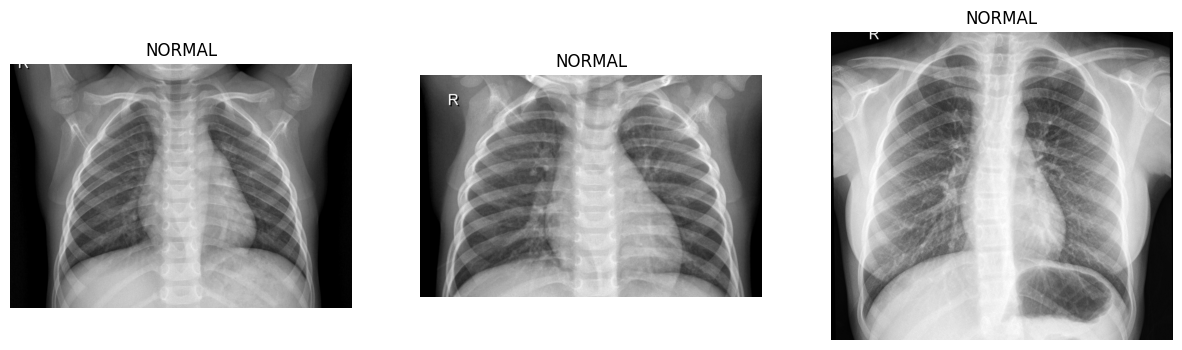

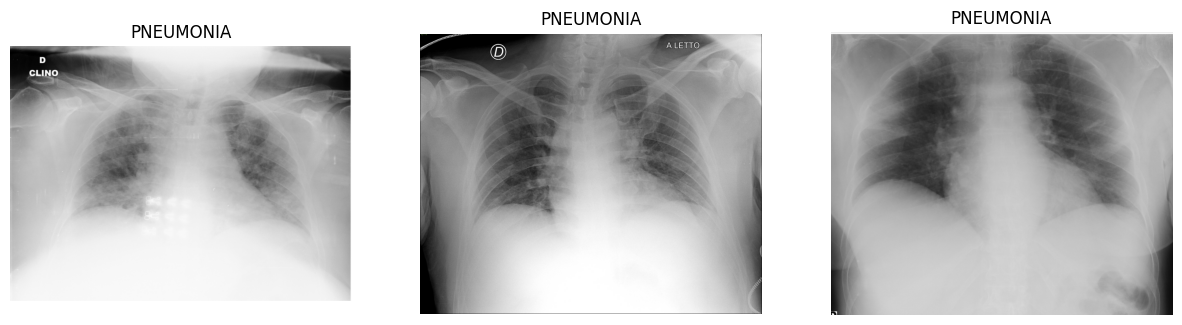

In [ ]:
# To Load and Explore the Data

data_dir = '/content/drive/MyDrive/archive (4)/xray_dataset_covid19'
classes = os.listdir(os.path.join(data_dir, 'train'))
print("Classes:", classes)

for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(data_dir, 'train', cls)))} images")

# To visualize sample images
def display_sample_images(data_dir, categories, num_images=3):
    for category in categories:
        category_path = os.path.join(data_dir, 'train', category)
        images = os.listdir(category_path)[:num_images]
        plt.figure(figsize=(15, 5))
        for i, image in enumerate(images):
            img_path = os.path.join(category_path, image)
            img = plt.imread(img_path)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(category)
            plt.axis('off')
        plt.show()

# To display sample images from training set
print("Sample images from training set:")
display_sample_images(data_dir, classes)


We can understand the difference between a normal chest x-ray image and the pneumonial chest x-ray image. We will make the model to understand the same difference, so that it will be able to do the prediction for diagnosis.

Here we use data augmentation techniques to expand our dataset artificially and improve the robustness of our model. The data will be rescaled, and the transformations such as rotation, width and height shifts, zoom, and horizontal flips an other adjustments will be done.

In [ ]:
# Data Preprocessing

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    subset='training'
)

validation_generator = valid_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    subset='validation'
)


Found 120 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


A set of hyperparameters with certain values have been defined, and the best configuration for our model to perform at its best was decided by training and evaluating the model with the different set of configurations. The landed configurations are by defining certain values for the following, and performing experiments with different values for each hyperparameter - learning_rate,	batch_size,	epochs,	dropout_rate,	num_conv_layers,	filters,	kernel_size,	activation_function,	optimizer, and	batch_normalization.

The experiments that was conducted has been recorded. The result being the performance of our model for each set of configuration.

Having run our model with the experiments and recording the result, we're now going to analyse the results and decide which is the best configuration. We visualize the model's performance to gain insights on the same.

,learning_rate,batch_size,epochs,dropout_rate,num_conv_layers,filters,kernel_size,activation_function,optimizer,batch_normalization,accuracy
0,0.00001,16,10,0.3,2,128,"(3, 3)",relu,sgd,False,0.500000
1,0.00100,32,10,0.3,1,128,"(3, 3)",relu,adam,False,1.000000
2,0.00100,16,30,0.5,1,32,"(3, 3)",tanh,adam,False,0.928571
3,0.00100,16,20,0.5,3,32,"(5, 5)",relu,adam,False,1.000000
4,0.00010,32,30,0.2,1,32,"(5, 5)",tanh,sgd,True,0.464286
5,0.00010,32,20,0.2,1,64,"(5, 5)",relu,sgd,False,0.500000
6,0.00100,32,30,0.5,2,128,"(3, 3)",tanh,sgd,False,0.750000
7,0.00010,32,10,0.5,1,128,"(3, 3)",relu,sgd,True,0.500000
8,0.00100,16,10,0.3,1,128,"(5, 5)",tanh,sgd,False,0.750000
9,0.00010,16,10,0.3,2,128,"(3, 3)",tanh,sgd,True,0.571429


Best Hyperparameters:


,learning_rate,batch_size,epochs,dropout_rate,num_conv_layers,filters,kernel_size,activation_function,optimizer,batch_normalization,accuracy
1,0.001,32,10,0.3,1,128,"(3, 3)",relu,adam,False,1.0


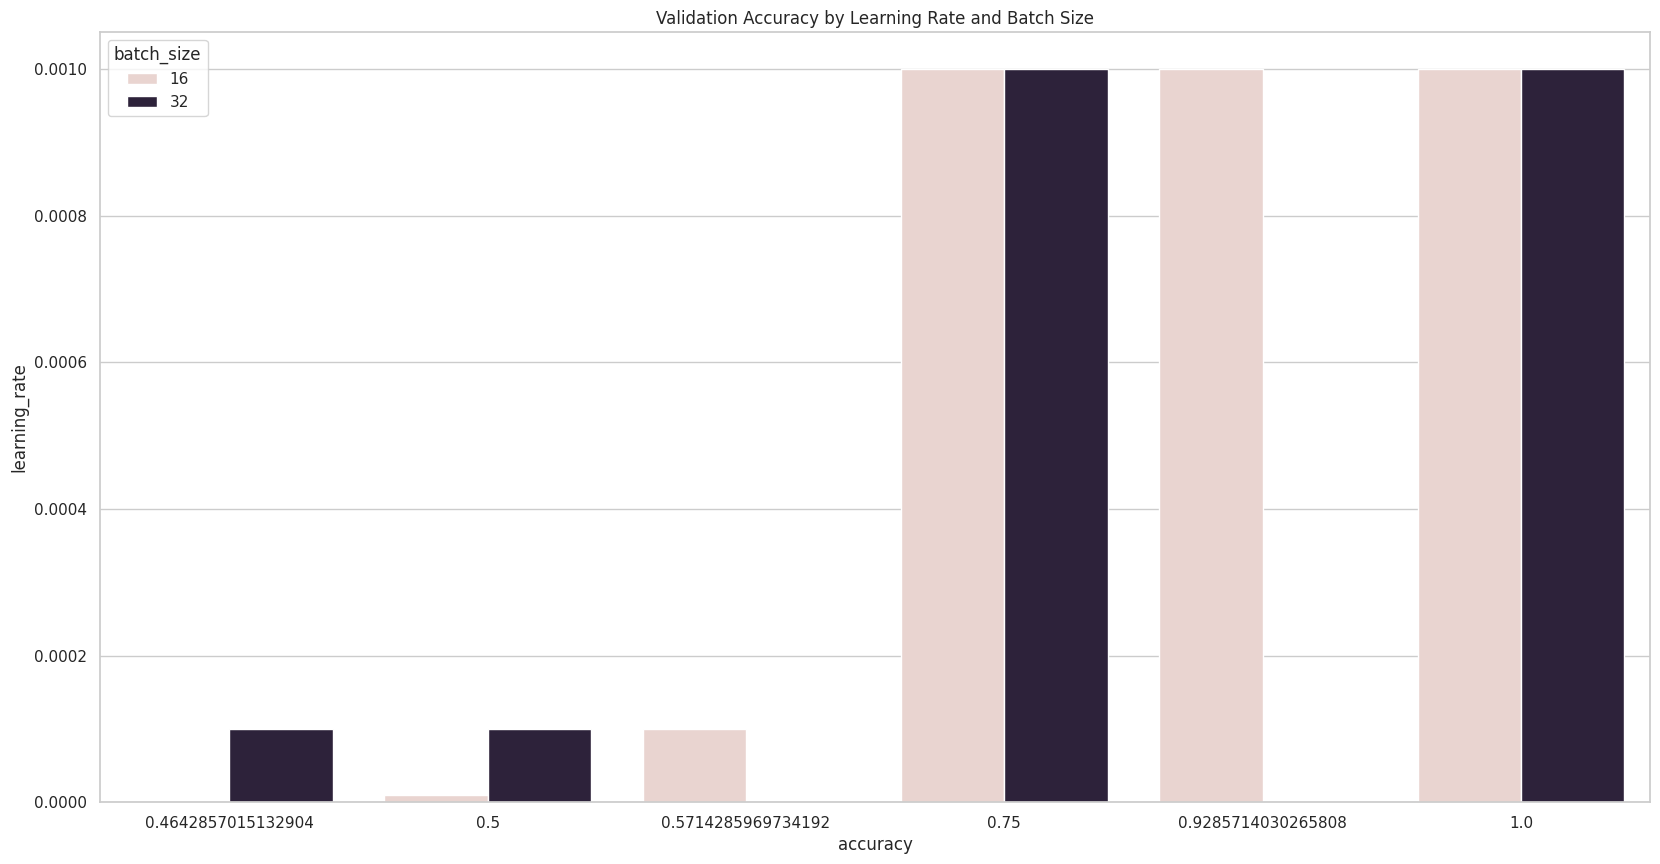

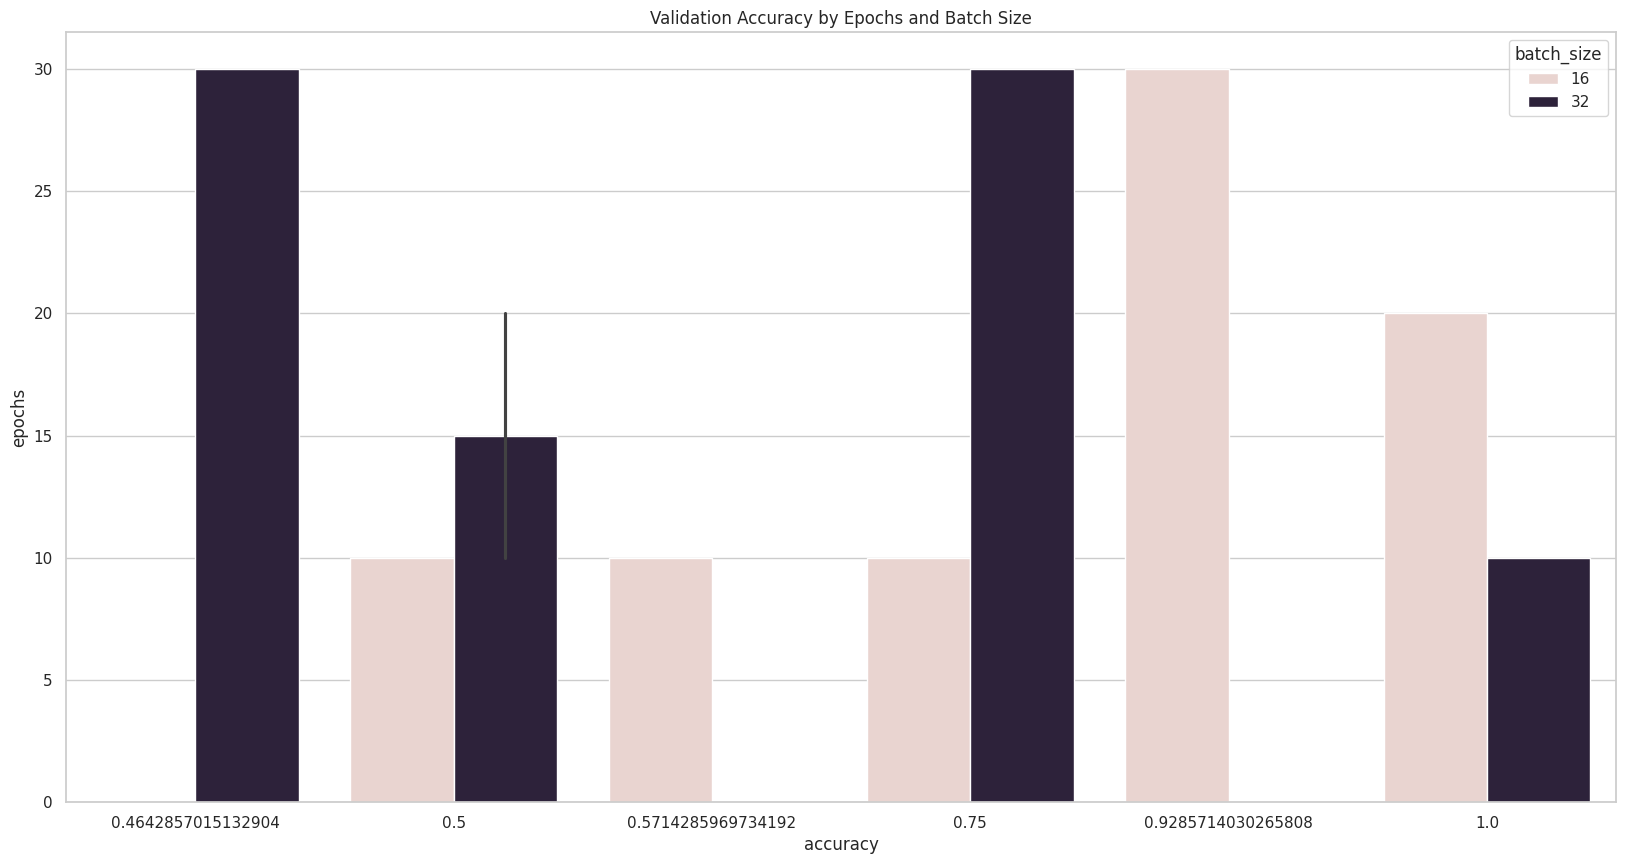

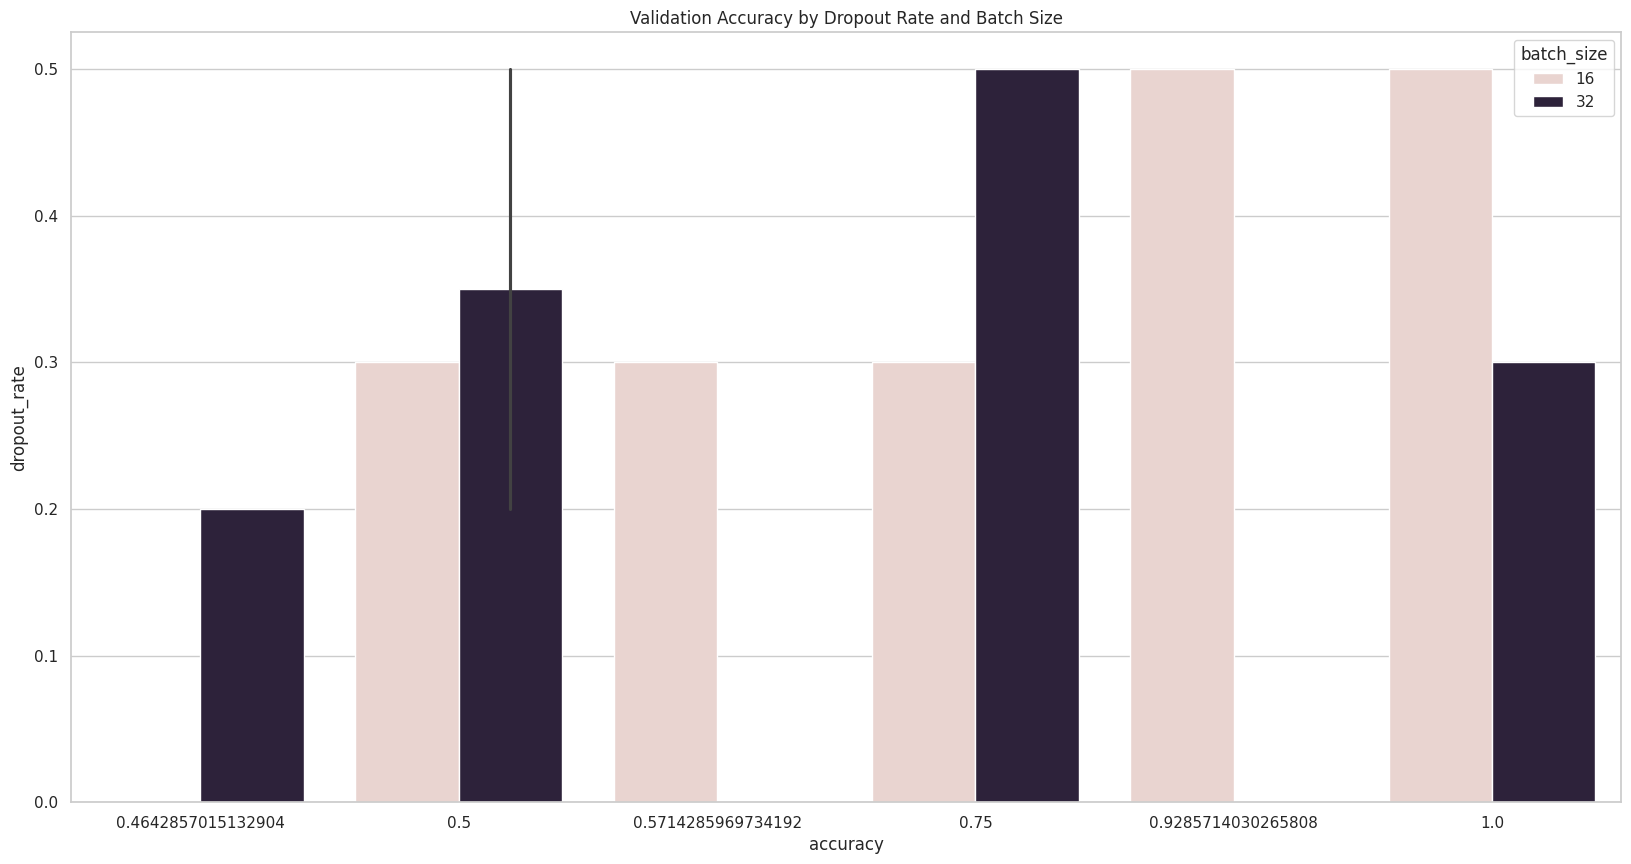

In [ ]:
from IPython.display import display, HTML
# Load the results
results_df = pd.read_csv('/content/drive/MyDrive/experiment_results.csv')

# To display the results
display(HTML(results_df.to_html()))

# To find the best hyperparameters
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print("Best Hyperparameters:")
display(HTML(best_result.to_frame().transpose().to_html()))

# To plot the results
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
sns.barplot(x='accuracy', y='learning_rate', data=results_df, hue='batch_size')
plt.title('Validation Accuracy by Learning Rate and Batch Size')
plt.show()

plt.figure(figsize=(20, 10))
sns.barplot(x='accuracy', y='epochs', data=results_df, hue='batch_size')
plt.title('Validation Accuracy by Epochs and Batch Size')
plt.show()

plt.figure(figsize=(20, 10))
sns.barplot(x='accuracy', y='dropout_rate', data=results_df, hue='batch_size')
plt.title('Validation Accuracy by Dropout Rate and Batch Size')
plt.show()

We can see that the best combination of hyperparameters for our model is

learning_rate            - 0.001,
batch_size                  - 32,
epochs                     -  10,
dropout_rate              -  0.3,
num_conv_layers          -     1,
filters                -      128,
kernel_size            -  (3, 3),
activation_function   -     relu,
optimizer               -   adam, and
batch_normalization     -   False,

and the accuracy is 100.00% at this configuration

As we have landed on the best configuration for our model, we are now going to train and test our best model.

In [ ]:
best_params = best_result.to_dict()

# To train the best model
best_model = create_model(
    dropout_rate=best_params['dropout_rate'],
    num_conv_layers=best_params['num_conv_layers'],
    filters=best_params['filters'],
    kernel_size=eval(best_params['kernel_size']),
    activation=best_params['activation_function'],
    batch_norm=best_params['batch_normalization']
)

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'sgd':
    optimizer = SGD(learning_rate=best_params['learning_rate'])

best_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(150, 150),
    batch_size=best_params['batch_size'],
    class_mode='binary',
    subset='training'
)

validation_generator = valid_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(150, 150),
    batch_size=best_params['batch_size'],
    class_mode='binary',
    subset='validation'
)

# Training the model
best_model.fit(
    train_generator,
    steps_per_epoch=max(train_generator.samples // train_generator.batch_size, 1),
    validation_data=validation_generator,
    validation_steps=max(validation_generator.samples // validation_generator.batch_size, 1),
    epochs=best_params['epochs'],
    verbose=1
)

# Evaluating the model on the test set
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(150, 150),
    batch_size=best_params['batch_size'],
    class_mode='binary'
)

test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Found 120 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Epoch 1/10
3/3 [==============================] - 6s 2s/step - loss: 0.8163 - accuracy: 0.4091 - val_loss: 0.6268 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 0.6443 - accuracy: 0.5417 - val_loss: 0.5548 - val_accuracy: 0.9286
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.5447 - accuracy: 0.8295 - val_loss: 0.4768 - val_accuracy: 0.8571
Epoch 4/10
3/3 [==============================] - 4s 1s/step - loss: 0.4641 - accuracy: 0.8409 - val_loss: 0.3239 - val_accuracy: 0.9286
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 0.3273 - accuracy: 0.9091 - val_loss: 0.2248 - val_accuracy: 0.9286
Epoch 6/10
3/3 [==============================] - 4s 1s/step - loss: 0.3011 - accuracy: 0.8977 - val_loss: 0.2704 - val_accuracy: 0.8929
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 0.2684 - accuracy: 0.8523 - 

The best model achieved a test accuracy of 92.50%

Generation of confusion matrix and classification report for the model.

2/2 [==============================] - 1s 170ms/step


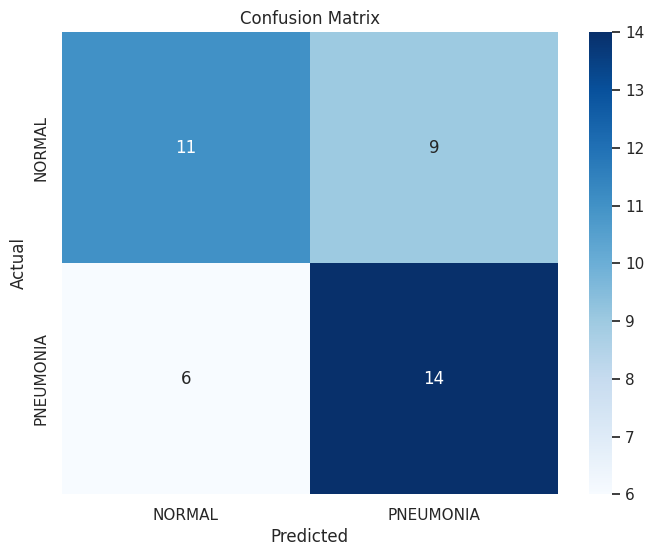

              precision    recall  f1-score   support

      NORMAL       0.65      0.55      0.59        20
   PNEUMONIA       0.61      0.70      0.65        20

    accuracy                           0.62        40
   macro avg       0.63      0.62      0.62        40
weighted avg       0.63      0.62      0.62        40



In [ ]:
test_generator.reset()
predictions = best_model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

The precision, recall, and F1-score indicates that while the model performed well with test accuracy of 92.50%, there is still room for improvement in distinguishing between COVID-19 and Normal cases properly.


### Key Insights:
1. **Transfer Learning**: By making use of the pre-trained VGG16 model, the initial performance has a considerable improvement. With this, the effectiveness of transfer learning in medical image classification tasks is becoming evident.
2. **Hyperparameter Tuning**: The experimentation that has been done with more hyperparameters was necessary in landing in the best model configuration. Eventhough the experiments were time consuming, we were able to establish the scenario for our model to perform at its best.

### Future Work

1. **Dataset Expansion**: More of the chest X-ray images can be collected, especially for COVID-19 cases, so that it would help to improve the model's performance and generalization.
2. **Advanced Architectures**: More advanced neural network architectures, such as ResNet or EfficientNet could be explored for this case, which might result in better performance of the model.
3. **Ensemble Methods**: We could combine multiple models using ensemble methods, so that it could enhance overall accuracy and robustness of the model.
4. **Fine-Tuning**: The pre-trained model could be further fine-tuned, like including more layers or other different fine-tuning strategies, could result in improved performance of the model.